## 1. Create a straight line dataset using linear regression formula (`weight * X + bias`)

In [31]:
# Setup code agnostic params
import torch
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

Set `weight=0.3` and `bias=0.9`, there should be at leaset 100 datapoints in total.

In [36]:
weight = 0.3
bias = 0.9

start = 0
end = 5
step = 0.025

X = torch.arange(start, end, step)
y = weight * X + bias

len(X), len(y)

(200, 200)

Split the data into 80/20 training and test sets

In [37]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(160, 160, 40, 40)

Plot training and test data

In [38]:
import matplotlib.pyplot as plt

def plot_predictions(X_train=X_train,
					 y_train=y_train,
					 X_test=X_test,
					 y_test=y_test,
					 predictions=None):
	
	plt.figure(figsize=(10,7))
	plt.scatter(x=X_train, y=y_train, c='b', s=4, label='Training data')
	plt.scatter(x=X_test, y=y_test, c='g', s=4, label='Test data')
	if predictions is not None:
		plt.scatter(x=X_test, y=predictions, c='r', s=7, label="Predictions")
	
	plt.legend()

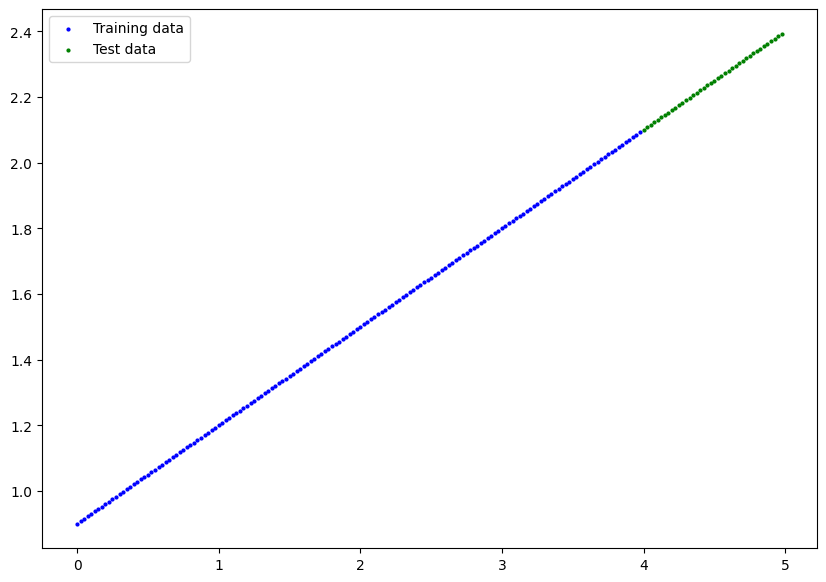

In [39]:
plot_predictions()

## 2. Build a PyTorch model by subclassing `nn.Module`

Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.

Implement `forward()` method to compute the linear regression function you've used to create dataset in exercise 1.

In [40]:
from torch import nn

class LinearRegressionExercise(nn.Module):
	def __init__(self):
		super().__init__()
		self.weights = nn.Parameter(torch.randn(1,
										  requires_grad=True,
										  dtype=torch.float))
		self.bias = nn.Parameter(torch.randn(1, 
									requires_grad=True,
									dtype=torch.float))
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.weights * x + self.bias

In [41]:
model = LinearRegressionExercise()
model, model.state_dict()

(LinearRegressionExercise(),
 OrderedDict([('weights', tensor([-1.6607])), ('bias', tensor([-1.3443]))]))

## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.

Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model params from the model that's been created in 2.

In [42]:
LR = 0.01
PARAMS = model.parameters()

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=PARAMS, lr=LR)

Write a training loop to perform the training for 300 epochs.

The training loop should test the model on the test dataset every 20 epochs.

In [43]:
EPOCHS = 300

model.to(device)

for epoch in range(EPOCHS+1):
	### TRAINING
	# Set the model to training mode
	model.train()

	# Transfer data to device
	X_train = X_train.to(device)
	y_train = y_train.to(device)
	X_test = X_test.to(device)
	y_test = y_test.to(device)

	# Make the forward pass
	y_pred = model(X_train)

	# Calculate the loss
	loss = loss_fn(y_pred, y_train)

	# Optimizer zero grad
	optimizer.zero_grad()

	# Backpropagation
	loss.backward()

	# Optimizer step
	optimizer.step()

	### TESTING
	# Set model to eval mode
	model.eval()

	with torch.inference_mode():
		test_pred = model(X_test)
		test_loss = loss_fn(test_pred, y_test)

	# Print training info each 20 epochs
	if epoch % 20 == 0:
		print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 6.1411895751953125 | Test loss: 10.943739891052246
Epoch: 20 | Loss: 5.151156902313232 | Test loss: 8.959954261779785
Epoch: 40 | Loss: 4.1611247062683105 | Test loss: 6.976171016693115
Epoch: 60 | Loss: 3.171093702316284 | Test loss: 4.992391109466553
Epoch: 80 | Loss: 2.181062698364258 | Test loss: 3.0086100101470947
Epoch: 100 | Loss: 1.191031813621521 | Test loss: 1.0248291492462158
Epoch: 120 | Loss: 0.4472041130065918 | Test loss: 0.5266702175140381
Epoch: 140 | Loss: 0.4079379141330719 | Test loss: 0.6184977889060974
Epoch: 160 | Loss: 0.3772473633289337 | Test loss: 0.5828571915626526
Epoch: 180 | Loss: 0.34661903977394104 | Test loss: 0.5356431007385254
Epoch: 200 | Loss: 0.3159894049167633 | Test loss: 0.4884292185306549
Epoch: 220 | Loss: 0.28535863757133484 | Test loss: 0.44121524691581726
Epoch: 240 | Loss: 0.25472888350486755 | Test loss: 0.39234787225723267
Epoch: 260 | Loss: 0.22410058975219727 | Test loss: 0.34513401985168457
Epoch: 280 | Loss: 0.19347

## 4. Make predictions with the trained model on the test data

In [45]:
model.eval()
with torch.inference_mode():
	y_preds = model(X_test)

y_preds[:5]

tensor([2.2814, 2.2925, 2.3035, 2.3146, 2.3256], device='mps:0')

Visualize the predictions against the original training and testing data

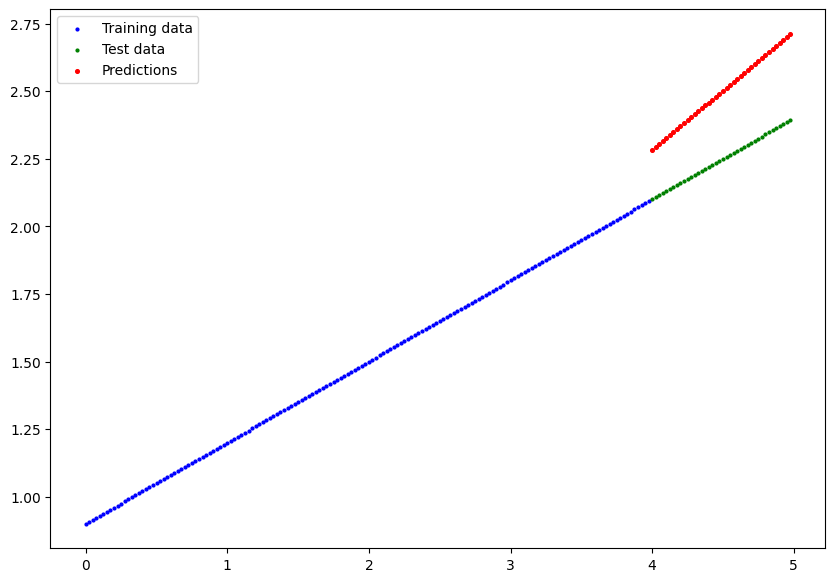

In [46]:
plot_predictions(predictions=y_preds.cpu())

## 5. Save trained model's `state_dict()` to file

In [48]:
from pathlib import Path

# Create paths for model to be saved
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_worflow_model_exercises.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
print(f"Saving model {MODEL_NAME} to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
		   f=MODEL_SAVE_PATH)

Saving model 01_pytorch_worflow_model_exercises.pth to models/01_pytorch_worflow_model_exercises.pth


Create a new instance of earlier created model class and load in the `state_dict()` that's just been saved

In [50]:
loaded_model = LinearRegressionExercise()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model, loaded_model.state_dict(), model.state_dict()

(LinearRegressionExercise(),
 OrderedDict([('weights', tensor([0.4421])), ('bias', tensor([0.5131]))]),
 OrderedDict([('weights', tensor([0.4421], device='mps:0')),
              ('bias', tensor([0.5131], device='mps:0'))]))

Perform prediction on test data with loaded model and confirm they match the original

In [54]:
loaded_model.to(device)
loaded_model.eval()
with torch.inference_mode():
	y_preds_loaded = loaded_model(X_test)

y_preds_loaded == y_preds

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='mps:0')